<font color = 'red'>
Content: 

1. [Importing Libraries](#1)
1. [Reading CSV File and Preprocessing](#2)
1. [Hyperparameters](#3)
1. [Selecting Device (GPU - CPU)](#4)
1. [Defining Dataset and Dataloader](#5)
1. [Display Frames](#6)
1. [Training FasterRCNN Model](#7)
1. [Saving Models](#8)
1. [Loading Model](#9)
1. [Testing on Video with OpenCV](#10)


<a id = "1"></a><br>
# Importing Libraries

In [1]:
from time import time
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

torch.cuda.empty_cache() 

import os
# for dirname, _, filenames in os.walk('D:/Downloads/Edge/archive'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

<a id = "2"></a><br>
# Reading CSV File and Preprocessing

In [2]:
DATA_PATH = 'D:/Downloads/Edge/archive'
os.listdir(DATA_PATH)

['Annotations',
 'daySequence1',
 'daySequence2',
 'dayTrain',
 'false',
 'fasterrcnn_resnet0_fpn.pth',
 'fasterrcnn_resnet10_fpn.pth',
 'fasterrcnn_resnet11_fpn.pth',
 'fasterrcnn_resnet12_fpn.pth',
 'fasterrcnn_resnet13_fpn.pth',
 'fasterrcnn_resnet14_fpn.pth',
 'fasterrcnn_resnet15_fpn.pth',
 'fasterrcnn_resnet16_fpn.pth',
 'fasterrcnn_resnet17_fpn.pth',
 'fasterrcnn_resnet18_fpn.pth',
 'fasterrcnn_resnet19_fpn.pth',
 'fasterrcnn_resnet1_fpn.pth',
 'fasterrcnn_resnet20_fpn.pth',
 'fasterrcnn_resnet21_fpn.pth',
 'fasterrcnn_resnet22_fpn.pth',
 'fasterrcnn_resnet23_fpn.pth',
 'fasterrcnn_resnet24_fpn.pth',
 'fasterrcnn_resnet25_fpn.pth',
 'fasterrcnn_resnet26_fpn.pth',
 'fasterrcnn_resnet27_fpn.pth',
 'fasterrcnn_resnet28_fpn.pth',
 'fasterrcnn_resnet29_fpn.pth',
 'fasterrcnn_resnet2_fpn.pth',
 'fasterrcnn_resnet30_fpn.pth',
 'fasterrcnn_resnet31_fpn.pth',
 'fasterrcnn_resnet32_fpn.pth',
 'fasterrcnn_resnet33_fpn.pth',
 'fasterrcnn_resnet34_fpn.pth',
 'fasterrcnn_resnet35_fpn.pth',
 '

In our project we use LISA traffic light dataset. The database is collected in San Diego, California, USA. The database provides four day-time and two night-time sequences primarily used for testing, providing 23 minutes and 25 seconds of driving in Pacific Beach and La Jolla, San Diego. The stereo image pairs are acquired using the Point Grey’s Bumblebee XB3 (BBX3-13S2C-60) which contains three lenses which capture images with a resolution of 1280 x 960, each with a Field of View(FoV) of 66°. Where the left camera view is used for all the test sequences and training clips. The training clips consists of 13 daytime clips and 5 nighttime clips.

In [3]:
DAY_TRAIN_PATH = 'D:/Downloads/Edge/archive/Annotations/Annotations/dayTrain/'
NIGHT_TRAIN_PATH = 'D:/Downloads/Edge/archive/Annotations/Annotations/nightTrain/'

In [4]:
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
    
train_day_df = pd.concat(train_day,axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 33.83it/s]


In [5]:
df = df.drop(['Origin file','Origin track','Origin track frame number'],axis=1)

In [6]:
def changeFilename(x):
    filename = x.Filename
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
   
    return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [7]:
df['Annotation tag'].unique()

array(['stop', 'stopLeft', 'go', 'goLeft', 'warningLeft'], dtype=object)

In [8]:
label_to_idx = {'go':1, 'warning':2, 'stop': 3}
idx_to_label = {v:k for k,v in label_to_idx.items()}

def changeAnnotation(x):
    if 'go' in x['Annotation tag']:
        return label_to_idx['go']
    elif 'warning' in x['Annotation tag']:
        return label_to_idx['warning']
    elif 'stop' in x['Annotation tag']:
        return label_to_idx['stop']
    
df['Annotation tag'] = df.apply(changeAnnotation,axis=1)

annotation_tags = df['Annotation tag'].unique()
annotation_tags

array([3, 1, 2], dtype=int64)

In [9]:
df.columns = ['image_id','label','x_min','y_min','x_max','y_max','frame']

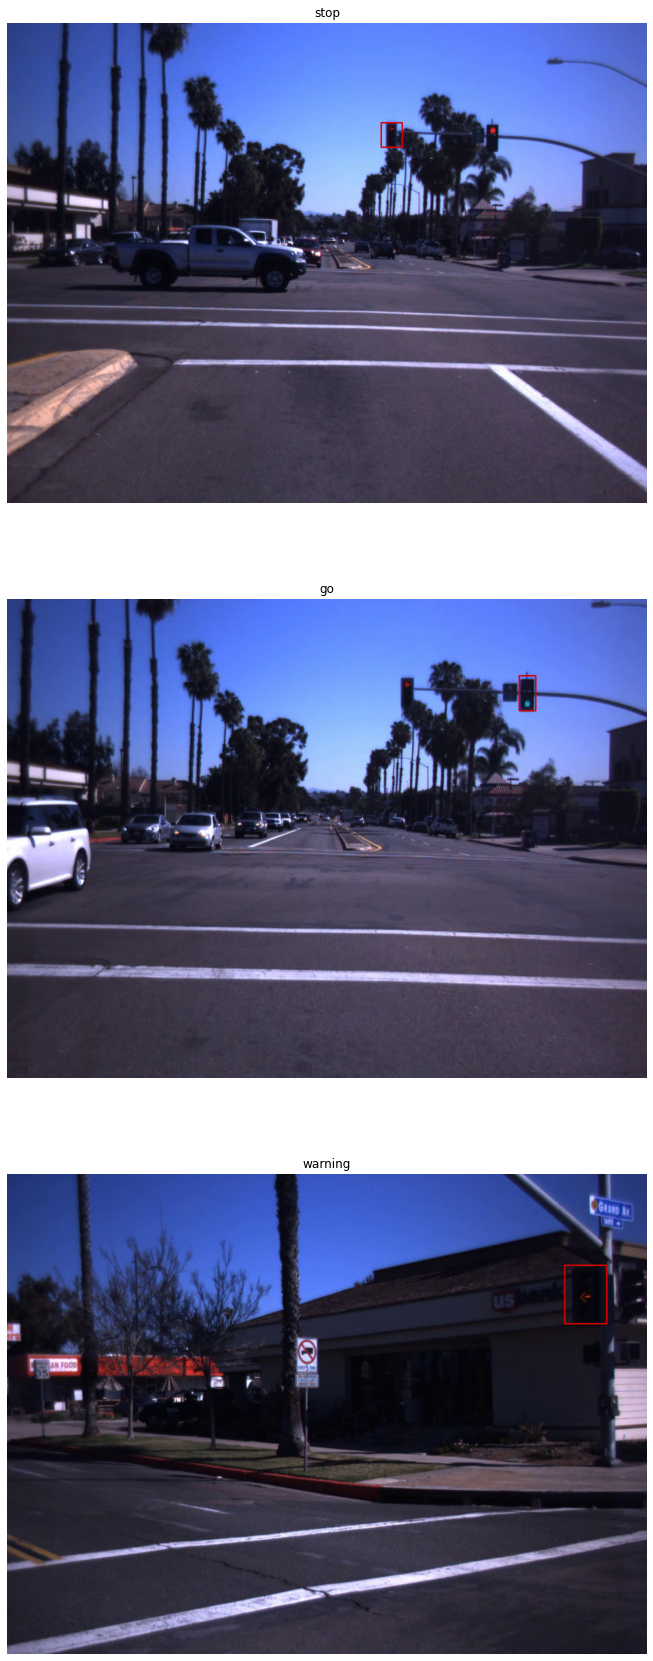

In [10]:
fig, ax = plt.subplots(len(annotation_tags),1,figsize=(15,10*len(annotation_tags)))

for i, tag in enumerate(annotation_tags):
    sample = df[df['label']==tag].sample(1)
    bbox = sample[['x_min','y_min','x_max','y_max']].values[0]
    
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 2)
    
    ax[i].set_title(idx_to_label[tag])
    ax[i].set_axis_off()
    ax[i].imshow(image)

In [11]:
df['clipNames'] = df[['image_id']].applymap(lambda x: x.split('/')[5])
df['clipNames'].unique()

array(['dayClip9'], dtype=object)

In [12]:
def split(df,p=0.25):
    clipNames = sorted(df['clipNames'].unique())

    dayClips = [name for name in clipNames if 'day' in name]

    testDayClipNames = list(np.random.choice(dayClips,int(len(dayClips)*p)))
    testClipNames =  testDayClipNames

    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainClipNames =  trainDayClipNames
    
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df


In [13]:
train_df, test_df = split(df)

In [14]:
train_df, val_df = split(train_df)

<a id = "3"></a><br>
# Hyperparameters

In [15]:
EPOCHS = 100
BATCH_SIZE = 2

<a id = "4"></a><br>
# Selecting Device (GPU - CPU)

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


<a id = "5"></a><br>
# Defining Dataset and Dataloader

In [18]:
class TrafficLightsDataset:
    def __init__(self, df, transforms=None):
        super().__init__()

        self.image_ids = df.image_id.unique()
        self.df = df
        self.transforms = transforms
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df.image_id == image_id]

        image = cv2.imread(image_id)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        boxes = records[['x_min','y_min','x_max','y_max']].values
        boxes = torch.as_tensor(boxes,dtype=torch.float32)
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = torch.as_tensor(records.label.values, dtype=torch.int64)
        
        iscrowd = torch.zeros_like(labels, dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.as_tensor(sample['bboxes'],dtype=torch.float32)
            target['labels'] = torch.as_tensor(sample['labels'])
            
        return image, target, image_id

In [19]:
class LossAverager:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [21]:
def getTrainTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getValTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def getTestTransform():
    return A.Compose([
        A.Resize(height=256, width=256, p=1),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [22]:
trainDataset = TrafficLightsDataset(train_df,getTrainTransform())
valDataset = TrafficLightsDataset(val_df,getValTransform())
testDataset = TrafficLightsDataset(test_df,getTestTransform())

In [23]:
trainDataLoader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valDataLoader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

testDataLoader = DataLoader(
    testDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

<a id = "6"></a><br>
# Display Frames 

In [24]:
images, targets, image_ids = next(iter(trainDataLoader))

boxes = targets[0]['boxes'].numpy().astype(np.int32)
image = images[0].permute(1,2,0).numpy()

In [25]:
def displayImage(image, boxes):
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 1)

    ax.set_axis_off()
    ax.imshow(image)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


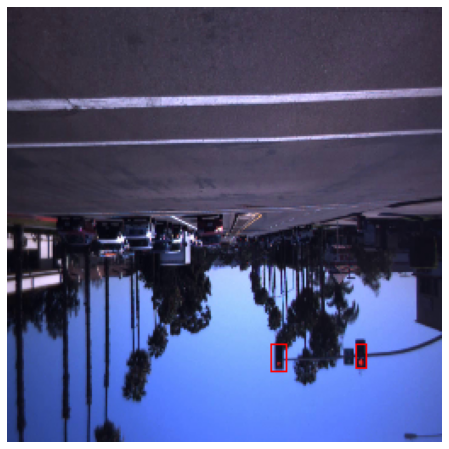

In [26]:
displayImage(image,boxes)

<a id = "7"></a><br>
# Training FasterRCNN Model

In [27]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

N_CLASS = 4 

INP_FEATURES = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(INP_FEATURES, N_CLASS)

In [28]:
model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
lossHist = LossAverager()
valLossHist = LossAverager()

for epoch in range(EPOCHS):
    
    start_time = time()
    model.train()
    lossHist.reset()
    
    for images, targets, image_ids in tqdm(trainDataLoader):
        
        images = torch.stack(images).to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        bs = images.shape[0]
        
        loss_dict = model(images, targets)
        
        totalLoss = sum(loss for loss in loss_dict.values())
        lossValue = totalLoss.item()
        
        lossHist.update(lossValue,bs)

        optimizer.zero_grad()
        totalLoss.backward()
        optimizer.step()
    
    if lr_scheduler is not None:
        lr_scheduler.step(totalLoss)

    print(f"[{str(timedelta(seconds = time() - start_time))[2:7]}]")
    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"Train loss: {lossHist.avg}")
    
#     if(epoch == 1):
#         torch.save(model.state_dict(), 'fasterrcnn_resnet10_fpn.pth'.format(epoch))

    torch.save(model.state_dict(), 'D:/Downloads/Edge/archive/false/fasterrcnn_resnet{}_fpn.pth'.format(epoch))

100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:14<00:00,  1.51it/s]


[05:14]
Epoch 0/100
Train loss: 785.0690350889689


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:02<00:00,  1.57it/s]


[05:02]
Epoch 1/100
Train loss: 10033.248318001346


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:05<00:00,  1.56it/s]


[05:05]
Epoch 2/100
Train loss: 4082.871241093686


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [04:57<00:00,  1.59it/s]


[04:58]
Epoch 3/100
Train loss: 13205445.224947542


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:04<00:00,  1.56it/s]


[05:05]
Epoch 4/100
Train loss: 695961.5400592985


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:05<00:00,  1.55it/s]


[05:06]
Epoch 5/100
Train loss: 5.675850768842195


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:06<00:00,  1.55it/s]


[05:06]
Epoch 6/100
Train loss: 3.73309990719745


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:05<00:00,  1.55it/s]


[05:06]
Epoch 7/100
Train loss: 12.226540093798386


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:05<00:00,  1.55it/s]


[05:06]
Epoch 8/100
Train loss: 12.69307209466633


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:05<00:00,  1.55it/s]


[05:06]
Epoch 9/100
Train loss: 14.187979542079725


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:05<00:00,  1.55it/s]


[05:06]
Epoch 10/100
Train loss: 3.5265480638805187


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:05<00:00,  1.55it/s]


[05:06]
Epoch 11/100
Train loss: 5.376416748699389


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:05<00:00,  1.55it/s]


[05:05]
Epoch 12/100
Train loss: 13.832971082988538


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:03<00:00,  1.56it/s]


[05:04]
Epoch 13/100
Train loss: 853408267.0718943


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:06<00:00,  1.55it/s]


[05:06]
Epoch 14/100
Train loss: 25661.763377749794


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:07<00:00,  1.55it/s]


[05:07]
Epoch 15/100
Train loss: 38495.30685745741


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:05<00:00,  1.55it/s]


[05:05]
Epoch 16/100
Train loss: 11.236908853806947


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:05<00:00,  1.55it/s]


[05:06]
Epoch 17/100
Train loss: 4.859697237830413


100%|████████████████████████████████████████████████████████████████████████████████| 475/475 [05:07<00:00,  1.54it/s]


[05:07]
Epoch 18/100
Train loss: 5.028798731847814


 55%|███████████████████████████████████████████▊                                    | 260/475 [02:48<02:20,  1.53it/s]

In [37]:
torch.save(model.state_dict(), 'fasterrcnn_resnet1_fpn.pth'.format(epoch))

<a id = "8"></a><br>
# Saving Models

In [129]:
torch.save(model.state_dict(), 'D:/Downloads/Edge/archive/fasterrcnn_resnet53_fpn.pth'.format(epoch))

<a id = "9"></a><br>
# Loading Models

In [17]:
model.load_state_dict(torch.load('D:/Downloads/Edge/archive/fasterrcnn_resnet50_fpn.pth'))

<All keys matched successfully>

<a id = "10"></a><br>
# Testing on Video with OpenCV

In [84]:
from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
import json

In [85]:
class npEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.int32):
            return int(obj)
        return json.JSONEncoder.default(self, obj)

In [86]:
def write_video(file_path, frames, fps):
    """
    Writes frames to an mp4 video file
    :param file_path: Path to output video, must end with .mp4
    :param frames: List of PIL.Image objects
    :param fps: Desired frame rate
    """

    
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    writer = cv2.VideoWriter(file_path, fourcc, fps, (image.shape[1], image.shape[0]))

    for frame in frames:
        writer.write(frame)

    writer.release() 

In [ ]:
preprocess = transforms.Compose([
    transforms.ToTensor()
])

#путь к тестовому видео

cap = cv2.VideoCapture('D:/Downloads/Edge/phase_I-20210331T101401Z-001/phase_I/video_0.mp4')

model.eval()

frames = []
frame_count = 0

dicty = []

traffic_light = 0

with torch.no_grad():
    while(True):
        ret, input = cap.read()
        
        if ret == False:
            break
        
        image = input.copy()
        input = preprocess(input).float()
        input = input.unsqueeze_(0)
        input = input.type(torch.cuda.FloatTensor)

        result = model(input)

        boxes = result[0]['boxes'].type(torch.cuda.FloatTensor)
        scores = result[0]['scores'].type(torch.cuda.FloatTensor)
        labels = result[0]['labels'].type(torch.cuda.FloatTensor)

        mask = nms(boxes,scores,0.3)
        boxes = boxes[mask]
        scores = scores[mask]
        labels = labels[mask]

        boxes = boxes.data.cpu().numpy().astype(np.int32)
        scores = scores.data.cpu().numpy()
        labels = labels.data.cpu().numpy()

        mask = scores >= 0.5
        boxes = boxes[mask]
        scores = scores[mask]
        labels = labels[mask]

        colors = {1:(0,255,0), 2:(255,255,0), 3:(255,0,0)}
        
        
        for box,label in zip(boxes,labels):
            image = cv2.rectangle(image,
                          (box[0], box[1]),
                          (box[2], box[3]),
                          colors[label], 2)
            if colors[label] == (0, 255, 0):
                colour = 'green'
            if colors[label] == (255, 255, 0):
                colour = 'yellow'
            if colors[label] == (255, 0, 0):
                colour = 'red'
            
            dict_list = {
                frame_count: {
                    'traffic_light_' + str(traffic_light): {
                            'coords': list(box),
                            'state': colour,
                            'affect': 'True'
                            }
              }

              }
            
            
            dicty.append(dict_list)
            
            traffic_light += 1
                
        #splitting into frames
        #здесь папка в которую выводились все кадры
        
        name = '{0}.jpg'.format(frame_count)
        name = os.path.join('D:/Downloads/Edge/archive/frames_of_video', name)
        cv2.imwrite(name, image)
        #print('writing to file:{0}'.format(name))
        
        frames.append(image)        
        
        frame_count += 1
        
        cv2.waitKey(0)
#cюда записавался json файл
        
with open('D:/Downloads/Edge/archive/video/dict.json', 'w') as json_file:
    json.dump(dicty, json_file, cls=npEncoder)
        

cap.release()
cv2.destroyAllWindows()

In [44]:
#в самом конце формирование видео (предсказанного) из тех самых кадров
write_video('D:/Downloads/Edge/archive/video/demo_0.mp4', frames, 30)